In [1]:
import pandas as pd
import json
import ast
import csv

In [2]:
ibm = pd.read_json('IBM_Api_sentiments.json')
azure = pd.read_json('Azure_Api_sentiments.json')
google = pd.read_json('Google_Api_sentiments.json')
aws = pd.read_json('AWS_Api_sentiments.json')

In [4]:
def IBMScores(df):
    doclist = [d.get('document') for d in df['sentiment']]
    j = 0
    for i in doclist:
        df['sentiment'][j] = i['score']
        j+=1
    return df

def AzureScores(df):
    doclist = [d.get('score') for d in df['documents']]
    df['sentiment_score'] = doclist
    return df

def GoogleScores(df):
    for i in range(len(df)):
        df[0][i] = df[0][i].split(' ; Sentiment: ')[1]
    return df

def json_data(json, dataframe):
    json_data = pd.read_json(json)
    max_score = json_data[json_data['SentimentScore'] == json_data['SentimentScore'].max()]
    dataframe = pd.concat([dataframe, max_score], axis = 0)
    return dataframe

In [275]:
ibm = extractIBMScores(ibm)
ibm.drop(columns=['language', 'usage'], inplace=True)
azure = extractAzureScores(azure)
azure.drop(columns='documents', inplace=True)
google = extractGoogleScores(google)
google[0] = pd.to_numeric(google[0])
aws_df = pd.DataFrame()
for i in range(len(aws)):
    aws_df = json_data(aws[0][i],aws_df)
aws_df.drop(columns=['ResponseMetadata', 'Sentiment'], inplace=True)
aws_df.reset_index(drop=True, inplace=True)

In [276]:
list = [ibm, azure, google, aws_df]
combined_dataframe=pd.concat(list,axis=1)

In [279]:
combined_dataframe.columns = ['IBM', 'Azure', 'Google', 'AWS']
combined_dataframe.head(5)

,IBM,Azure,Google,AWS
0,0.760051,0.958107,0.3,0.514261
1,0.908944,0.961736,0.4,0.820620
2,-0.675144,0.500000,0.0,0.946000
3,0.707989,0.500000,0.6,0.710918
4,0.806287,0.500000,0.3,0.572770


In [280]:
combined_dataframe.to_csv('all_api_raw_scores.csv', index=False)

In [281]:
def normalize(df):
    for col in df.columns:
        mins = df[col].min()
        maxs = df[col].max()
        df[col] = df[col].apply(lambda k : 2*(k - mins)/(maxs - mins) - 1)
    return df

In [282]:
normdf = normalize(combined_dataframe)
normdf.head(5)

,IBM,Azure,Google,AWS
0,0.748455,0.917346,0.250,-0.392441
1,0.904623,0.925213,0.375,0.487387
2,-0.756862,-0.075690,-0.125,0.847464
3,0.693850,-0.075690,0.625,0.172334
4,0.796950,-0.075690,0.250,-0.224411


In [283]:
normdf.to_csv('all_api_normalized_scores.csv', index=False)

In [298]:
def bucketingScores(se):
    if se > (1/3):
        return 'positive'
    elif se < (-1/3):
        return 'negative'
    else:
        return 'neutral'

for i in normdf.columns:
    normdf[i + '_Sentiments'] = normdf[i].apply(lambda x : bucketingScores(x))

In [303]:
def averagingScores(se):
    se['Average_score'] = (se['IBM'] + se['Azure'] + se['Google'] + se['AWS'])/4
    return se
normdf = averagingScores(normdf)
normdf['Average_Sentiments'] = normdf.Average_score.apply(lambda x : bucketingScores(x))

In [306]:
normdf.head(5)

,IBM,Azure,Google,AWS,IBM_Sentiments,Azure_Sentiments,Google_Sentiments,AWS_Sentiments,Average_score,Average_Sentiments
0,0.748455,0.917346,0.250,-0.392441,positive,positive,neutral,negative,0.380840,positive
1,0.904623,0.925213,0.375,0.487387,positive,positive,positive,positive,0.673056,positive
2,-0.756862,-0.075690,-0.125,0.847464,negative,neutral,neutral,positive,-0.027522,neutral
3,0.693850,-0.075690,0.625,0.172334,positive,neutral,positive,neutral,0.353873,positive
4,0.796950,-0.075690,0.250,-0.224411,positive,neutral,neutral,neutral,0.186712,neutral


In [307]:
normdf.to_csv('average_norm_score_with_label.csv', index=False)

In [284]:
gj = pd.read_json('google_call_earnings.json')
nj = pd.read_json('NETFLIX_Q3_2018_EARNINGS_CALL_TRANSCRIPT_FANG.json')
aj = pd.read_json('Amazon_Q3_2018_Earning_Call_Transcript_Sentiment_Manual.json')
mj = pd.read_json('microsoft.json')
fj = pd.read_json('FB_earnings_call_transcript.json')

In [285]:
merged = pd.concat([gj,fj,mj,nj,aj])
merged.reset_index(drop=True)
merged.shape

(622, 2)

In [9]:
merged.to_csv('merged.csv', index=False)

In [2]:
import csv

In [3]:
df = pd.read_csv('average_norm_score_with_label.csv')

In [4]:
df.head(5)

,IBM,Azure,Google,AWS,IBM_Sentiments,Azure_Sentiments,Google_Sentiments,AWS_Sentiments,Average_score,Average_Sentiments
0,0.748455,0.917346,0.250,-0.392441,positive,positive,neutral,negative,0.380840,positive
1,0.904623,0.925213,0.375,0.487387,positive,positive,positive,positive,0.673056,positive
2,-0.756862,-0.075690,-0.125,0.847464,negative,neutral,neutral,positive,-0.027522,neutral
3,0.693850,-0.075690,0.625,0.172334,positive,neutral,positive,neutral,0.353873,positive
4,0.796950,-0.075690,0.250,-0.224411,positive,neutral,neutral,neutral,0.186712,neutral


In [5]:
manual = pd.read_csv('merged.csv')

In [6]:
manual.head(5)

,text,sentiment
0,"Good day ladies and gentlemen, and welcome to ...",neutral
1,Thank you. Good afternoon everyone and welcome...,neutral
2,G&A expense trends in the third quarter were a...,neutral
3,"To give you a bit of a breakdown, the largest ...",positive
4,"That being said, we do remain very focused on ...",neutral


In [7]:
y_actual = manual['sentiment']

In [8]:
y_pred = df['Average_Sentiments']

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

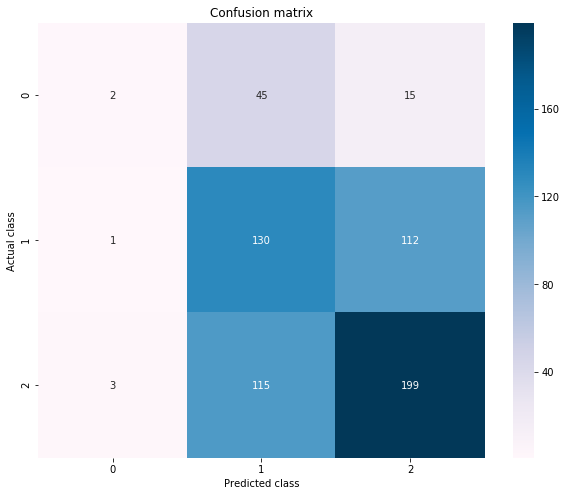

In [13]:
conf_matrix = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='PuBu')
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

In [12]:
accuracy = accuracy_score(y_actual, y_pred)
print(accuracy)

0.5321543408360129
